Miles Voenell HW #4

In [ ]:
import glob
import os
from pathlib import Path
from PIL import Image
import numpy as np

dog_images = glob.glob('../DataMining/DogImages/*/*')
annotations = glob.glob('../DataMining/Annotation/*/*')

def get_image(annot):
    img_path = '../DataMining/DogImages'
    file = annot.split('ion') 
    img_filename = img_path + file[-1] + '.jpg'
    return img_filename

#make new cropped images
for i in range(len(annotations)):
    dog = get_image(annotations[i])
    if os.path.exists(dog): 
        im = Image.open(dog)
        width, height = im.size
        new_width = new_height = min(width, height)
        left = (width - new_width) / 2
        top = (height - new_height) / 2
        right = (width + new_width) / 2
        bottom = (height + new_height) / 2
        im_cropped = im.crop((left, top, right, bottom))
        # Resize to 224x224
        im_resized = im_cropped.resize((224, 224), Image.Resampling.LANCZOS)
        im_resized = im_resized.convert("RGB")
        new_path = dog.replace("../DataMining/DogImages", "hw4_cropped/")
        head, tail = os.path.split(new_path)
        Path(head).mkdir(parents=True, exist_ok=True)
        im_resized.save(new_path)


Question #1 Feature Extraction

With some help from:
https://kozodoi.me/blog/20210527/extracting-features.

In [ ]:
import glob
import os
from pathlib import Path
from PIL import Image
import numpy as np

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#normalize
cropped_images = glob.glob("hw4_cropped/*/*")
normalized_dataset = []

for img_path in cropped_images:
    img = Image.open(img_path).convert('RGB')
    img_normalized = transform(img)
    normalized_dataset.append(img_normalized)

print(f"Normalized {len(normalized_dataset)} images.")

# Load pretrained ResNet18 model
resnet18 = models.resnet18(pretrained=True)

feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-2]) 
feature_extractor.eval()
features = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor.to(device)

for img_tensor in normalized_dataset:
    img_tensor = img_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        feature_map = feature_extractor(img_tensor)
        features.append(feature_map.cpu().squeeze().numpy())

print(f"Extracted features for {len(features)} images.")

features_array = np.array(features)
np.save("resnet18_features.npy", features_array)
print("Features saved to resnet18_features.npy.")


In [ ]:
total_images = len(features_array)
remaining_count = total_images - (171 + 157 + 181)

true_labels = np.array([0]*171 + [1]*157 + [2]*181 + [3]*remaining_count)

Question #2

Shape of features after flattening: (660, 25088)
Shape of features after PCA: (660, 2)


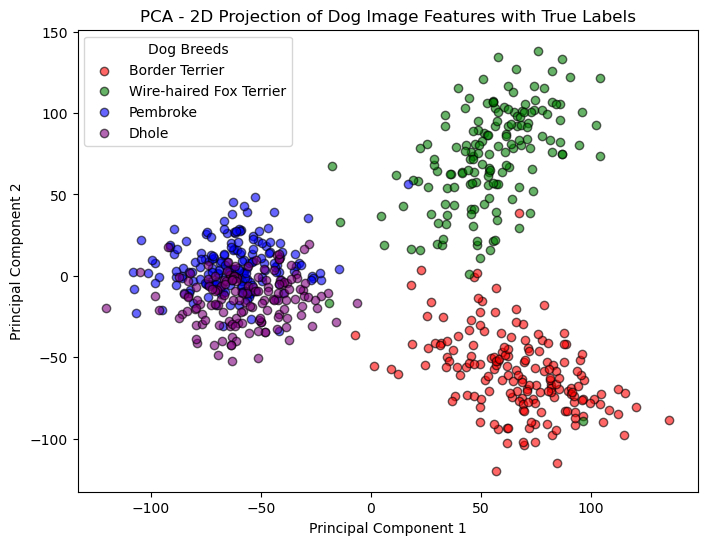

In [59]:
import numpy as np
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

features = np.load("resnet18_features.npy")
# Flatten
num_images, channels, height, width = features.shape
features_flattened = features.reshape(num_images, -1) 
#check shape
print("Shape of features after flattening:", features_flattened.shape)

#PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_flattened)

#check shape
print("Shape of features after PCA:", features_2d.shape)

#class 0 for Border Terrier, 1 for Wire-haired Fox Terrier, 2 for Pembroke, 3 for Dhole
breed_names = ['Border Terrier', 'Wire-haired Fox Terrier', 'Pembroke', 'Dhole'] 


y = np.array([0]*171 + [1]*157 + [2]*181 + [3]*(len(features_2d) - 171 - 157 - 181))
colormap = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(8, 6))
for label in np.unique(y):
    plt.scatter(features_2d[y == label, 0], features_2d[y == label, 1],
                color=colormap[label], label=breed_names[label], alpha=0.6, edgecolor='black')

plt.title('PCA - 2D Projection of Dog Image Features with True Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title="Dog Breeds")
plt.show()


Question #3  K-Means clustering and variants

In [ ]:
from sklearn.cluster import KMeans, BisectingKMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import os

os.environ["OMP_NUM_THREADS"] = "3" 
k = 4

#a. K-means Clustering with init='random'
kmeans_random = KMeans(n_clusters=k, init='random', random_state=42)
labels_random = kmeans_random.fit_predict(features_2d)

#b. K-means Clustering with init='k-means++'
kmeans_plus = KMeans(n_clusters=k, init='k-means++', random_state=42)
labels_plus = kmeans_plus.fit_predict(features_2d)

#c. Bisecting K-means with init='random'
bisecting_kmeans = BisectingKMeans(n_clusters=k, init='random', random_state=42)
labels_bisecting = bisecting_kmeans.fit_predict(features_2d)

#d. Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', n_neighbors=30, random_state=42)
labels_spectral = spectral.fit_predict(features_2d)

def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

K-Means Silouette and Graphs

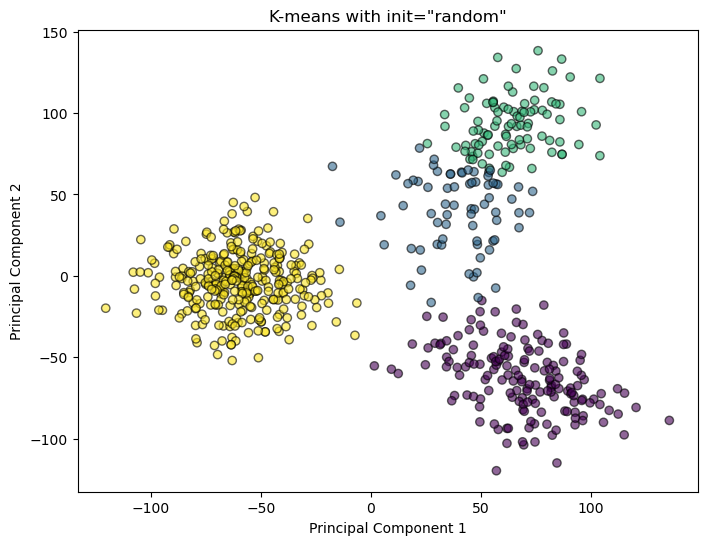

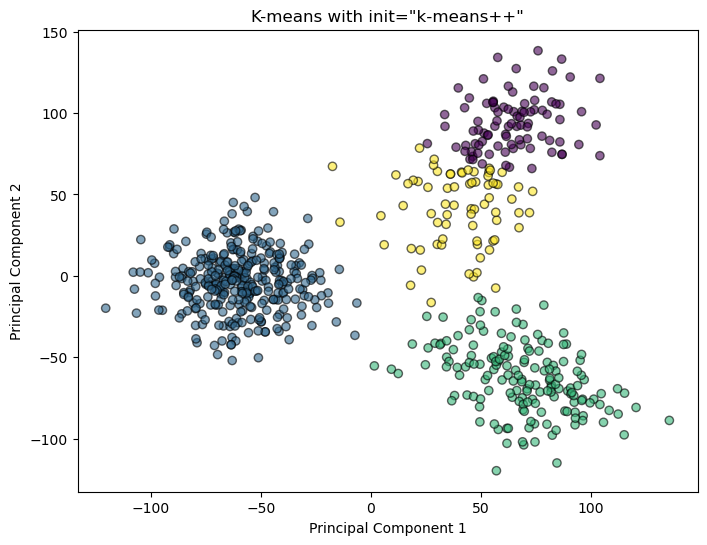

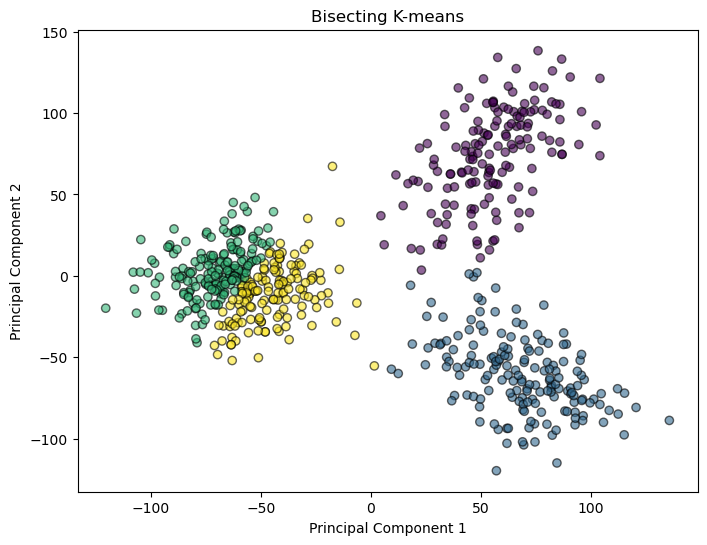

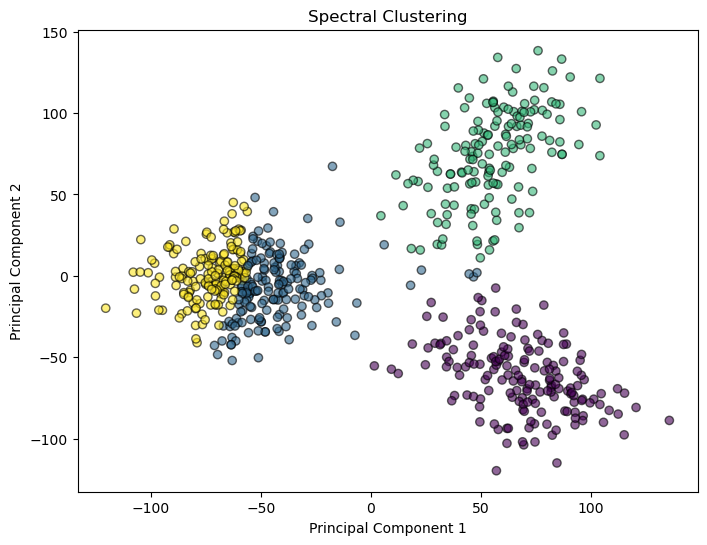

Silhouette Score for K-means (init='random'): 0.6218475699424744
Silhouette Score for K-means (init='k-means++'): 0.6233463287353516
Silhouette Score for Bisecting K-means: 0.47545793652534485
Silhouette Score for Spectral Clustering: 0.46631109714508057


In [ ]:
plot_clusters(features_2d, labels_random, 'K-means with init="random"')
plot_clusters(features_2d, labels_plus, 'K-means with init="k-means++"')
plot_clusters(features_2d, labels_bisecting, 'Bisecting K-means')
plot_clusters(features_2d, labels_spectral, 'Spectral Clustering')

silhouette_random = silhouette_score(features_2d, labels_random)
silhouette_plus = silhouette_score(features_2d, labels_plus)
silhouette_bisecting = silhouette_score(features_2d, labels_bisecting)
silhouette_spectral = silhouette_score(features_2d, labels_spectral)

print(f"Silhouette Score for K-means (init='random'): {silhouette_random}")
print(f"Silhouette Score for K-means (init='k-means++'): {silhouette_plus}")
print(f"Silhouette Score for Bisecting K-means: {silhouette_bisecting}")
print(f"Silhouette Score for Spectral Clustering: {silhouette_spectral}")

Question #3 DBSCAN and Agglomerative Clustering

I used eps = 12 and min_samples = 5 for DBSCAN to get 4 clusters

Number of unique clusters found by DBSCAN: 4


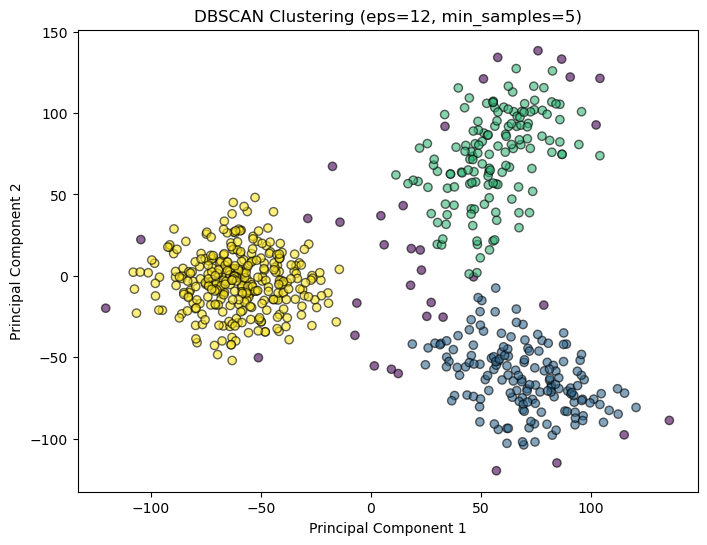

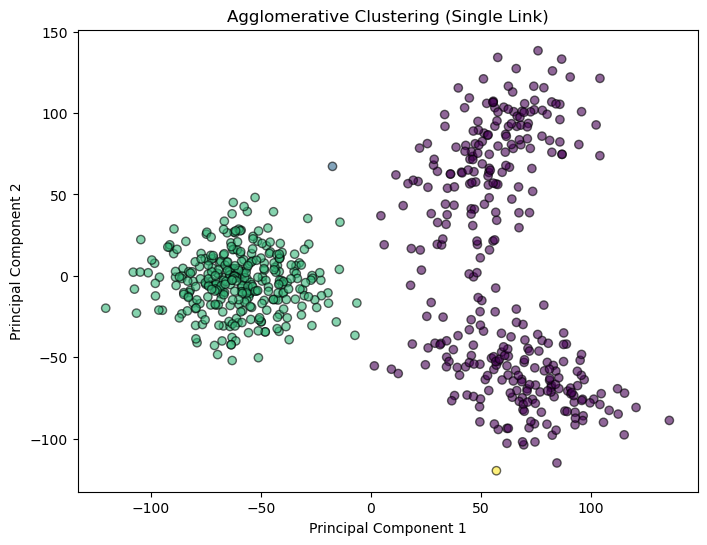

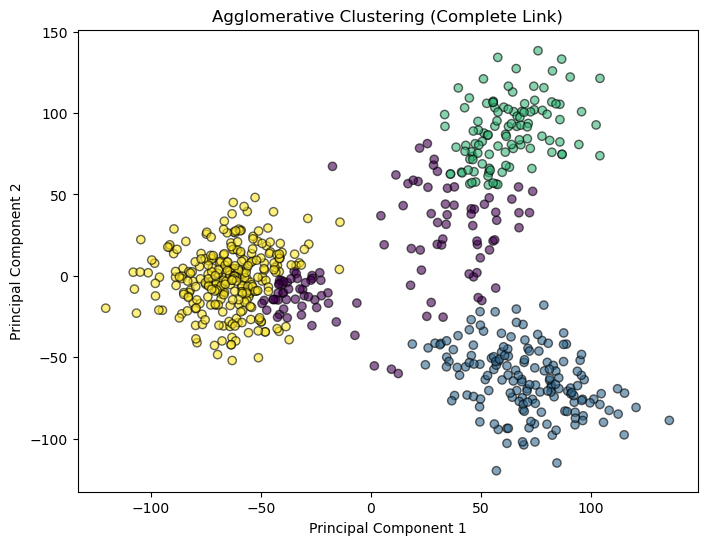

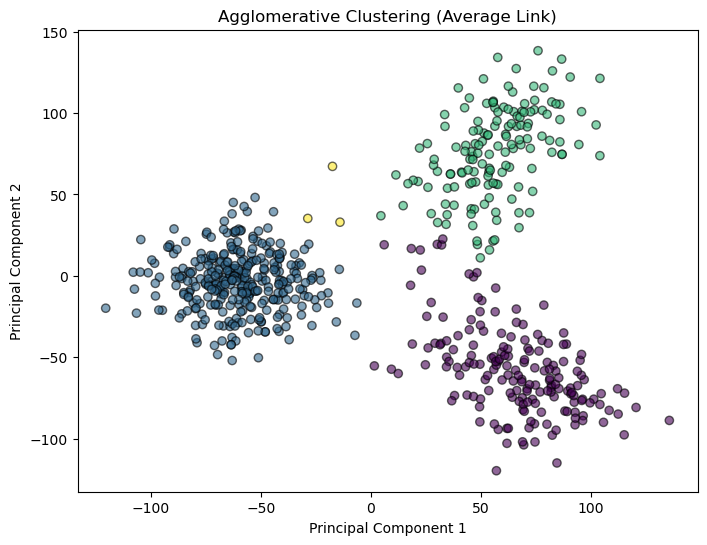

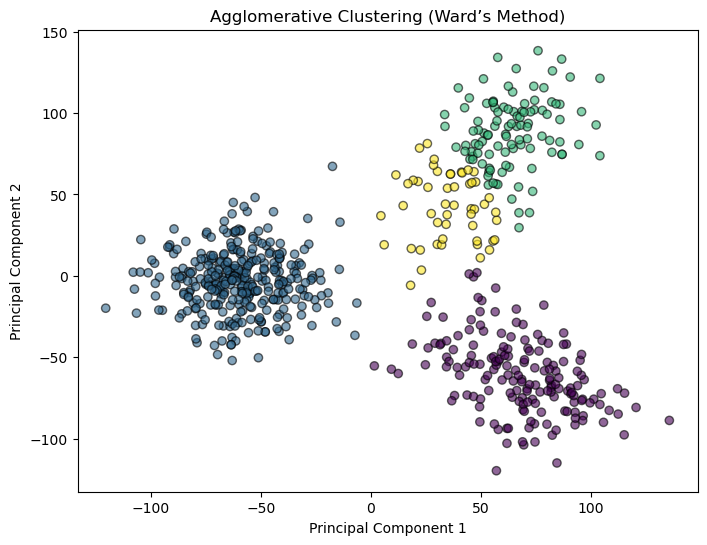

Silhouette Score for Agglomerative (Single Link): 0.20167486369609833
Silhouette Score for Agglomerative (Complete Link): 0.5028049349784851
Silhouette Score for Agglomerative (Average Link): 0.523784875869751
Silhouette Score for Agglomerative (Ward’s Method): 0.6027241349220276
Silhouette Score for DBSCAN: 0.6541


In [60]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# DBSCAN
eps = 12
min_samples = 5 

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(features_2d)

num_clusters_dbscan = len(set(labels_dbscan))
print(f"Number of unique clusters found by DBSCAN: {num_clusters_dbscan}")

# DBSCAN graph
plt.figure(figsize=(8, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels_dbscan, cmap='viridis', marker='o', edgecolor='black', alpha=0.6)
plt.title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#a. Single Link (MIN)
agg_single = AgglomerativeClustering(n_clusters=4, linkage='single')
labels_single = agg_single.fit_predict(features_2d)

#b. Complete Link (MAX)
agg_complete = AgglomerativeClustering(n_clusters=4, linkage='complete')
labels_complete = agg_complete.fit_predict(features_2d)

#c. Group Average
agg_average = AgglomerativeClustering(n_clusters=4, linkage='average')
labels_average = agg_average.fit_predict(features_2d)

#d. Ward’s Method
agg_ward = AgglomerativeClustering(n_clusters=4, linkage='ward')
labels_ward = agg_ward.fit_predict(features_2d)

#graph agglomerative clustering
def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='black', alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_clusters(features_2d, labels_single, 'Agglomerative Clustering (Single Link)')
plot_clusters(features_2d, labels_complete, 'Agglomerative Clustering (Complete Link)')
plot_clusters(features_2d, labels_average, 'Agglomerative Clustering (Average Link)')
plot_clusters(features_2d, labels_ward, 'Agglomerative Clustering (Ward’s Method)')

# silouette
silhouette_dbscan = silhouette_score(valid_features, valid_labels)
silhouette_single = silhouette_score(features_2d, labels_single)
silhouette_complete = silhouette_score(features_2d, labels_complete)
silhouette_average = silhouette_score(features_2d, labels_average)
silhouette_ward = silhouette_score(features_2d, labels_ward)

print(f"Silhouette Score for Agglomerative (Single Link): {silhouette_single}")
print(f"Silhouette Score for Agglomerative (Complete Link): {silhouette_complete}")
print(f"Silhouette Score for Agglomerative (Average Link): {silhouette_average}")
print(f"Silhouette Score for Agglomerative (Ward’s Method): {silhouette_ward}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")


Question #4 a and c Rank of Fowlkes-Mallows Index

In [55]:
from sklearn.metrics import fowlkes_mallows_score

#find fmi
fmi_kmeans_random = fowlkes_mallows_score(true_labels, labels_random)
fmi_kmeans_plus = fowlkes_mallows_score(true_labels, labels_plus)
fmi_bisecting = fowlkes_mallows_score(true_labels, labels_bisecting)
fmi_spectral = fowlkes_mallows_score(true_labels, labels_spectral)
fmi_dbscan = fowlkes_mallows_score(true_labels, labels_dbscan)

fmi_agg_single = fowlkes_mallows_score(true_labels, labels_single)
fmi_agg_complete = fowlkes_mallows_score(true_labels, labels_complete)
fmi_agg_average = fowlkes_mallows_score(true_labels, labels_average)
fmi_agg_ward = fowlkes_mallows_score(true_labels, labels_ward)

fmi_scores = {
    "K-means (init='random')": fmi_kmeans_random,
    "K-means (init='k-means++')": fmi_kmeans_plus,
    "Bisecting K-means": fmi_bisecting,
    "Spectral Clustering": fmi_spectral,
    "DBSCAN": fmi_dbscan,
    "Agglomerative (Single Link)": fmi_agg_single,
    "Agglomerative (Complete Link)": fmi_agg_complete,
    "Agglomerative (Average Link)": fmi_agg_average,
    "Agglomerative (Ward's Method)": fmi_agg_ward
}

sorted_fmi_scores = sorted(fmi_scores.items(), key=lambda x: x[1], reverse=True)

print("Ranking of Clustering Methods based on Fowlkes-Mallows Index:")
for method, score in sorted_fmi_scores:
    print(f"{method}: {score:.4f}")


Ranking of Clustering Methods based on Fowlkes-Mallows Index:
Agglomerative (Average Link): 0.7824
DBSCAN: 0.7522
Bisecting K-means: 0.7482
Agglomerative (Ward's Method): 0.7389
K-means (init='k-means++'): 0.7308
K-means (init='random'): 0.7295
Spectral Clustering: 0.7240
Agglomerative (Single Link): 0.6971
Agglomerative (Complete Link): 0.6852


Question #4 B and D Rank of Silouette Coefficient

In [56]:
#siloutte scores-
silhouette_scores = {
    "K-Means (init='random')": silhouette_random,
    "K-Means (init='k-means++')": silhouette_plus,
    "Bisecting K-Means": silhouette_bisecting,
    "Spectral Clustering": silhouette_spectral,
    "DBSCAN": silhouette_dbscan,
    "Agglomerative (Single Link)": silhouette_single,
    "Agglomerative (Complete Link)": silhouette_complete,
    "Agglomerative (Average Link)": silhouette_average,
    "Agglomerative (Ward’s Method)": silhouette_ward
}

sorted_silhouette_scores = sorted(silhouette_scores.items(), key=lambda x: x[1], reverse=True)

print("Ranking of Clustering Methods based on Silhouette Coefficient:")
for method, score in sorted_silhouette_scores:
    print(f"{method}: {score:.4f}")


Ranking of Clustering Methods based on Silhouette Coefficient:
DBSCAN: 0.6541
K-Means (init='k-means++'): 0.6233
K-Means (init='random'): 0.6218
Agglomerative (Ward’s Method): 0.6027
Agglomerative (Average Link): 0.5238
Agglomerative (Complete Link): 0.5028
Bisecting K-Means: 0.4755
Spectral Clustering: 0.4663
Agglomerative (Single Link): 0.2017
